### [Story](https://www.pivotaltracker.com/story/show/187949220)
### [Source](https://medium.com/@prathammodi001/keras-cnn-tutorial-classifying-images-made-easy-fb55cc8892ec)

Create from scratch a CNN apllied to computer vision, to classify cats and dogs from a well known image dataset published in [Kaggle](https://www.kaggle.com/c/dogs-vs-cats/overview).

## Dog Breed Classifier CNN

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="-1" 

import tensorflow as tf
import tensorflow_hub as hub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

2024-07-15 12:04:15.808663: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
print(tf.__version__)
if tf.config.list_logical_devices('GPU'):
    print("Yes,  GPU available")
else:
    print("No GPU available")

2.17.0
No GPU available


### Dataset 

In [3]:
# Load dataset
pd.set_option('display.max_columns', None) # show all columns
pd.set_option('display.max.rows', None) # showw all rows

labels_csv = pd.read_csv("./dataset/labels.csv")
labels_csv.describe()

,id,breed
count,10222,10222
unique,10222,120
top,000bec180eb18c7604dcecc8fe0dba07,scottish_deerhound
freq,1,126


<function matplotlib.pyplot.legend(*args, **kwargs) -> 'Legend'>

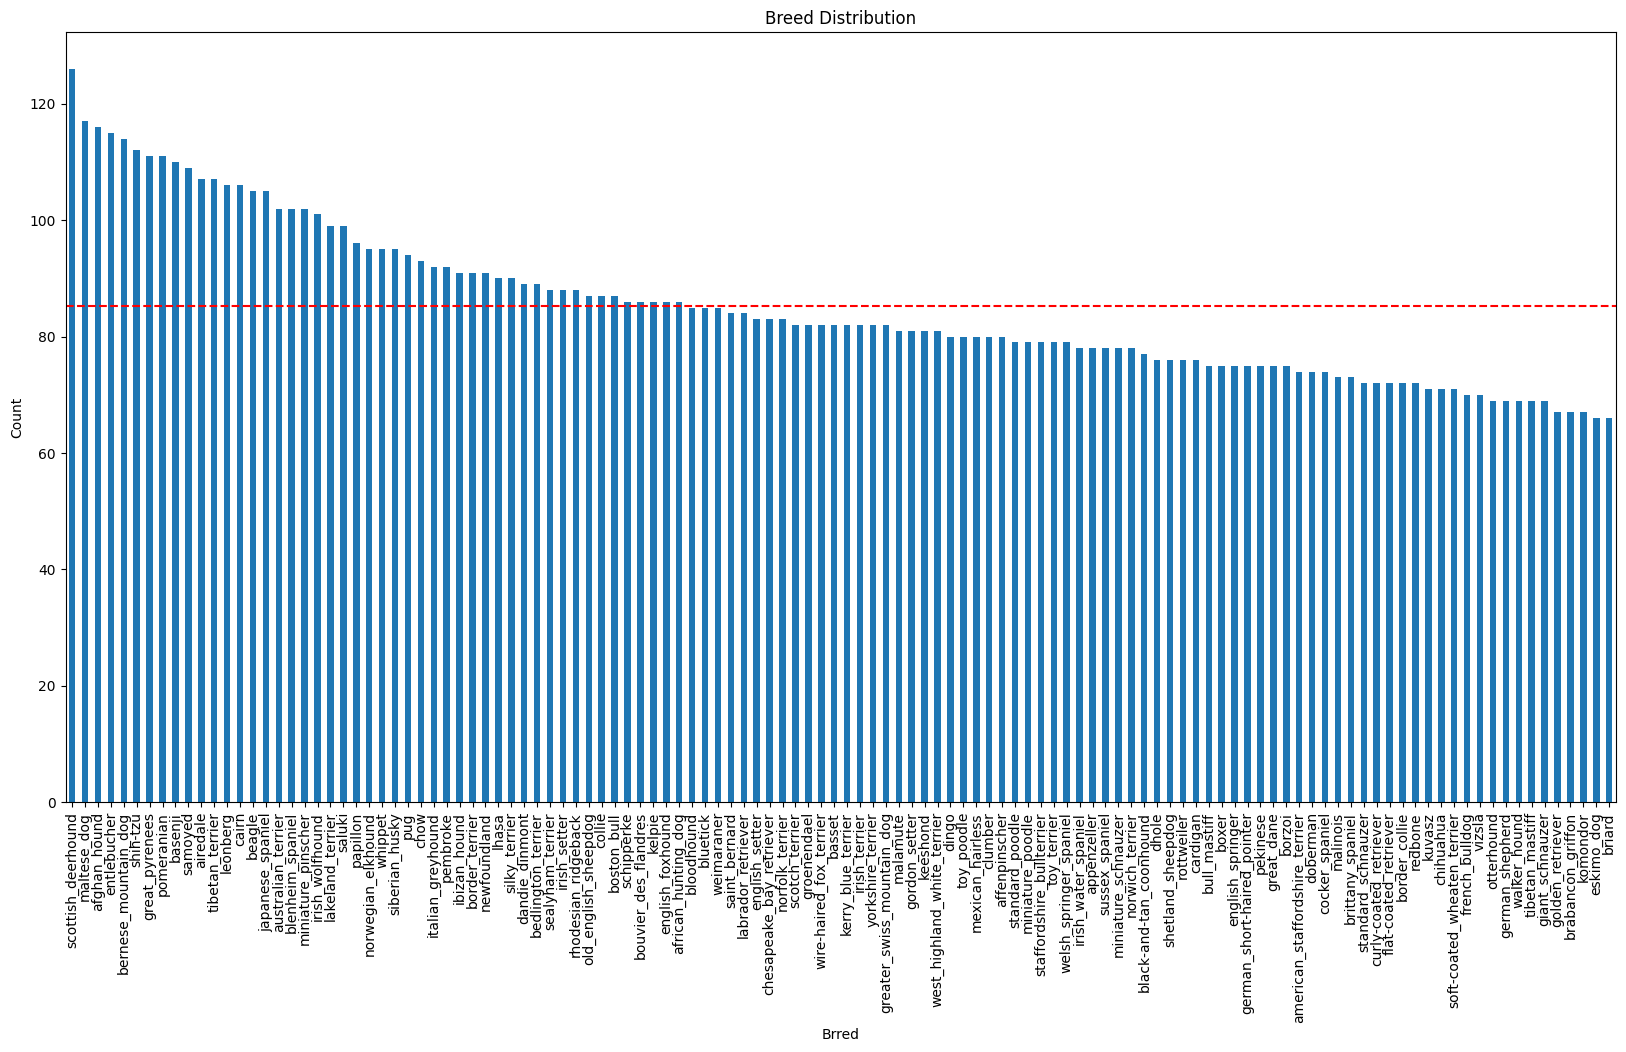

In [4]:
# EDA (exploratory data analysis)
ax = labels_csv["breed"].value_counts().plot.bar(figsize=(20,10))

average_value = labels_csv["breed"].value_counts().mean()
ax.axhline(average_value, color="red", linestyle="--", label="Average")

plt.xlabel("Brred")
plt.ylabel("Count")
plt.title("Breed Distribution")
plt.legend


### Get images and their labels

In [5]:
from IPython.display import Image

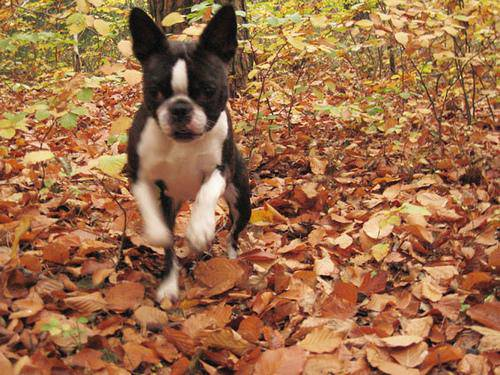

In [6]:
# Test one image
for image in labels_csv["id"].head(1):
    display(Image(filename="./dataset/train/"+image+".jpg", width=300, height="300"))

In [7]:
# get al images
filenames = []
for image_id in labels_csv["id"]:
    filenames.append("./dataset/train/"+image_id+".jpg")

filenames

['./dataset/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 './dataset/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 './dataset/train/001cdf01b096e06d78e9e5112d419397.jpg',
 './dataset/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 './dataset/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 './dataset/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 './dataset/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 './dataset/train/002a283a315af96eaea0e28e7163b21b.jpg',
 './dataset/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 './dataset/train/0042188c895a2f14ef64a918ed9c7b64.jpg',
 './dataset/train/004396df1acd0f1247b740ca2b14616e.jpg',
 './dataset/train/0067dc3eab0b3c3ef0439477624d85d6.jpg',
 './dataset/train/00693b8bc2470375cc744a6391d397ec.jpg',
 './dataset/train/006cc3ddb9dc1bd827479569fcdc52dc.jpg',
 './dataset/train/0075dc49dab4024d12fafe67074d8a81.jpg',
 './dataset/train/00792e341f3c6eb33663e415d0715370.jpg',
 './dataset/train/007b5a16db9d9ff9d7ad39982703e429.jpg',
 './dataset/train/007b8a0788282

In [8]:
# check if all filenames of all images have been acquired
if len(os.listdir("./dataset/train")) == len(filenames):
    print("Correct! Filenames match amount of files!")
else:
    print("Error! Filenames do not match amount of files")

Correct! Filenames match amount of files!


### labels

In [9]:
labels = labels_csv["breed"].to_numpy()

labels

array(['boston_bull', 'dingo', 'pekinese', ..., 'airedale',
       'miniature_pinscher', 'chesapeake_bay_retriever'], dtype=object)

In [10]:
# check for missing data, lables or images
if len(filenames) == len(labels):
    print("No missing Data!")
else:
    print("Missing data!!!")

No missing Data!


In [11]:
unique_breeds = labels
labels[0] == unique_breeds

boolean_labels = []

for label in labels:
    boolean_labels.append(label == unique_breeds)

## Prepare Train, Valid and Test sets

In [12]:
X = filenames
y = boolean_labels

NUM_IMAGES= 1000

from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X[:NUM_IMAGES], y[:NUM_IMAGES], test_size=0.2, random_state=42)
len(X_train), len(y_train), len(X_val), len(y_val)

(800, 800, 200, 200)

## Images to tensors

1. Take an image as input
2. Use Tensorflow to read the file and save it to a variable `image`
3. Turn the `image` (.jpeg) into Tensors
4. Normalize the `image`
5. Resize the `image` to 224x224
6. Return the processed image

In [13]:
# test 1
image = plt.imread(filenames[42])
image.shape

(257, 350, 3)

In [14]:
# Test 2. 
tensor = tf.io.read_file(filenames[20])
#tensor

In [15]:
# Test 3. Normalization: Turn image into numerical Tensor values: 0-255 (RGB)
tensor = tf.image.decode_jpeg(tensor, channels=3)
tensor

<tf.Tensor: shape=(375, 500, 3), dtype=uint8, numpy=
array([[[125, 128, 117],
        [121, 124, 113],
        [114, 120, 108],
        ...,
        [ 96, 124,  65],
        [ 95, 123,  64],
        [ 99, 127,  68]],

       [[116, 119, 108],
        [112, 118, 106],
        [109, 115, 103],
        ...,
        [ 94, 122,  61],
        [ 92, 120,  59],
        [ 95, 123,  62]],

       [[112, 118, 108],
        [110, 118, 107],
        [109, 117, 106],
        ...,
        [ 92, 121,  57],
        [ 88, 117,  53],
        [ 89, 118,  54]],

       ...,

       [[228, 227, 225],
        [230, 229, 227],
        [232, 228, 227],
        ...,
        [217, 214, 209],
        [201, 198, 193],
        [189, 186, 181]],

       [[221, 220, 218],
        [233, 232, 230],
        [242, 238, 237],
        ...,
        [220, 217, 212],
        [219, 216, 211],
        [215, 212, 207]],

       [[239, 238, 236],
        [235, 234, 232],
        [226, 222, 221],
        ...,
        [207, 204, 19

In [16]:
# Test 4. : convert RGB numbers 0-255 into 0-1 for each RGB
tf.image.convert_image_dtype(tensor, tf.float32)

<tf.Tensor: shape=(375, 500, 3), dtype=float32, numpy=
array([[[0.4901961 , 0.5019608 , 0.45882356],
        [0.47450984, 0.48627454, 0.4431373 ],
        [0.44705886, 0.47058827, 0.42352945],
        ...,
        [0.37647063, 0.48627454, 0.25490198],
        [0.37254903, 0.48235297, 0.2509804 ],
        [0.38823533, 0.49803925, 0.26666668]],

       [[0.454902  , 0.4666667 , 0.42352945],
        [0.43921572, 0.46274513, 0.4156863 ],
        [0.427451  , 0.45098042, 0.4039216 ],
        ...,
        [0.36862746, 0.4784314 , 0.2392157 ],
        [0.36078432, 0.47058827, 0.23137257],
        [0.37254903, 0.48235297, 0.24313727]],

       [[0.43921572, 0.46274513, 0.42352945],
        [0.43137258, 0.46274513, 0.41960788],
        [0.427451  , 0.45882356, 0.4156863 ],
        ...,
        [0.36078432, 0.47450984, 0.22352943],
        [0.34509805, 0.45882356, 0.20784315],
        [0.34901962, 0.46274513, 0.21176472]],

       ...,

       [[0.8941177 , 0.89019614, 0.882353  ],
        [0.90

In [17]:
IMG_SIZE = 224
# Takes an image file path and turns it into a Tensor
def preprocess_image(image_path, img_size=IMG_SIZE):
    # 1. read image
    image = tf.io.read_file(image_path)
    # 2. turn it into numerical Tensor using 3 channels RGB
    image = tf.image.decode_jpeg(image, channels=3)
    # 3. Normalize: convert 0-255 values into 0-1 for each RGB
    image = tf.image.convert_image_dtype(image, tf.float32)
    # 4. Resize to 224x224
    image = tf.image.resize(image, size=[IMG_SIZE,IMG_SIZE])
    # 5 return image
    return image

In [18]:
# Batch size data: function to return a tuple (image, label)
def get_image_label(image_path, label):
    image = preprocess_image(image_path)
    return image, label   

In [19]:
BATCH_SIZE = 32
""" Creates batches of data out of image (X) and lable (y) pairs"""
def create_batches(X, y=None, batch_size = BATCH_SIZE, valid_data = False, test_data = False):
    if test_data: # NO labels
        print("Creating Test data Batches...")
        data_whole = tf.data.Dataset.from_tensor_slices((tf.constant(X),))
        data_batch = data_whole.map(preprocess_image).batch(BATCH_SIZE)
        return data_batch

    elif valid_data: 
        print("Creating Valid Data batches...")
        data_whole = tf.data.Dataset.from_tensor_slices((tf.constant(X), tf.constant(y)))
        data_batch = data_whole.map(get_image_label).batch(BATCH_SIZE)
        return data_batch
    else: # Trainig set
        print("Creating Training Data Batches...")
        data_whole = tf.data.Dataset.from_tensor_slices((tf.constant(X), tf.constant(y)))
        data_batch = data_whole.shuffle(buffer_size=len(X)).map(get_image_label).batch(BATCH_SIZE)
        return data_batch  

In [20]:
train_data = create_batches(X_train, y_train)
val_data = create_batches(X_val, y_val, valid_data=True)

Creating Training Data Batches...
Creating Valid Data batches...


### Visualize Data Batches

In [21]:
# function to view images
def show_25_images(images, labels):
    plt.figure(figsize=(10,10))
    for i in range(25):
        ax = plt.subplot(5,5,i+1)
        plt.imshow(images[i])
        plt.title(unique_breeds[labels[i].argmax()])
        plt.axis("off")
    



### Training Images

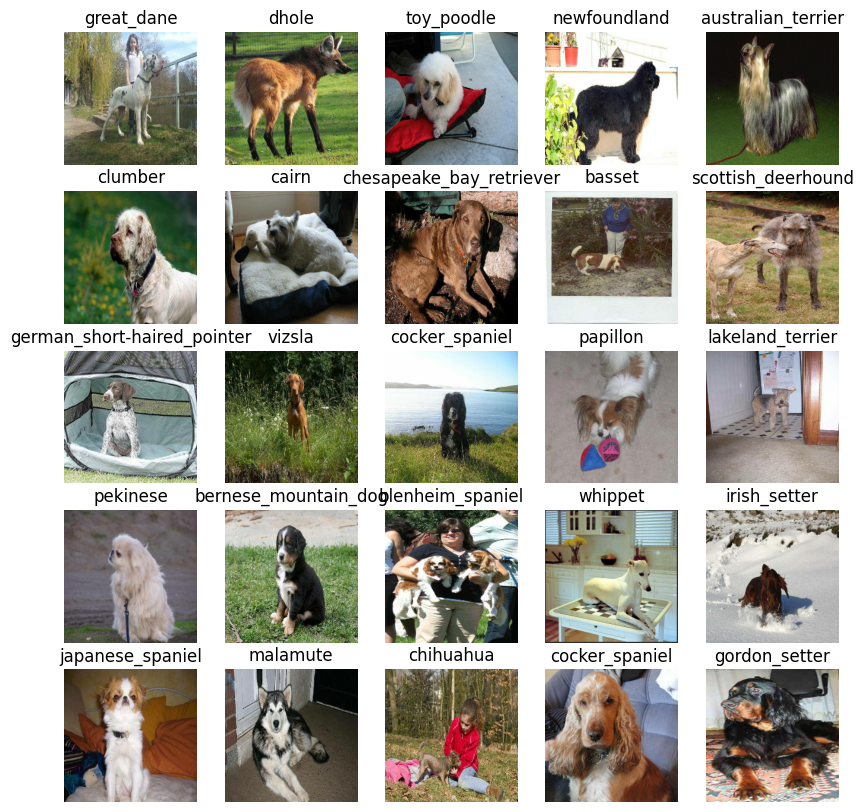

In [22]:
train_images, train_labels = next(train_data.as_numpy_iterator())
show_25_images(train_images, train_labels) 

### Validation Images

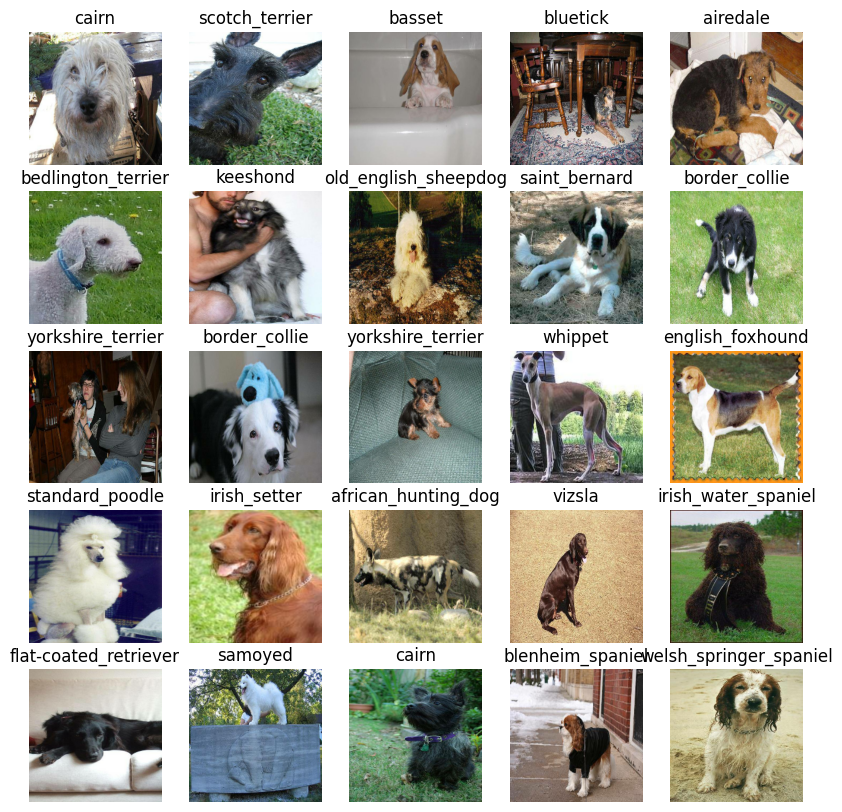

In [23]:
val_images, val_labels = next(val_data.as_numpy_iterator())
show_25_images(val_images, val_labels)

### Build Model

To build a model,  the following must be defined:
- Input shape - shape of images
- Output shape - shape of labels
- URL of the model to be used from Tensorflow Hub

In [ ]:
# Shape of Images
INPUT_SHAPE = [None, IMG_SIZE, IMG_SIZE, 3]

# Shape of labels
OUTPUT_SHAPE = len(unique_breeds)

# setup model URL
MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5"

In [ ]:
# Create a funtion to:
- takes input, output shapes and model as parameters
- defines layers in a Keras model in sequential
- compiles de model
- builds the model
- returns the model

In [ ]:
def create_model(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE, model_url=MODEL_URL):
    print("Building a Model with the URL: ", MODEL_URL)

    